# Federated Learning Test

This notebook is a test of federated learning using the MNIST dataset. It distributes partial subsets of the MNIST data to each worker and tests the results of federation of the workers. It also skews the subsets to investigate the value of federation in cases where workers have substantially different samples.

## The Baseline

First, we load up the common elements to be used in the traditional and federated approaches. 


### The Model
We start with the model.

In [1]:
import time
import datetime

run_data = {}

run_data['Date'] = datetime.datetime.today().strftime('%Y-%m-%d %H:%M:%S')
run_data['Global Start Time'] = time.time()

In [2]:
# Define the model

import torch.nn as nn

class MLPNet(nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc3 = nn.Linear(256, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def name(self):
        return "MLP"

# # Optional model for fun

# import torch.nn.functional as F

# class LeNet(nn.Module):
#     def __init__(self):
#         super(LeNet, self).__init__()
#         self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
#         self.conv2_drop = nn.Dropout2d()
#         self.fc1 = nn.Linear(320, 50)
#         self.fc2 = nn.Linear(50, 10)

#     def forward(self, x):
#         x = F.relu(F.max_pool2d(self.conv1(x), 2))
#         x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
#         x = x.view(-1, 320)
#         x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
#         x = self.fc2(x)
#         return F.log_softmax(x, dim=0) # value 0 was chosen arbitrarily to quiet a warning. Penny'll start a fire.

#     def name(self):
#         return 'LeNet'

### The Data - Standard MNIST Datasets
Here we get plain vanilla MNIST datasets, balanced the way the gods intended, and we make datatloaders from them. Nothing exciting to see here. This is our baseline. If you don't already have the MNIST data on your machine, the calls to `torchvision.datasets.MNIST(... dowload=True ...)` will download it for you.

In [3]:
# load the data

import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms

# create standard datasets using all of the MNIST data

data_path = './MNIST-data/raw'
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

train_dset = dsets.MNIST(root=data_path, download=True, train=True, transform=trans)
test_dset = dsets.MNIST(root=data_path, download=True, train=False, transform=trans)

In [4]:
# create dataloaders

from torch.utils.data import DataLoader

run_data['Batch Size'] = batch_size = 64

# create standard dataloaders using all of the MNIST data - this is for baseline purposes
train_dloader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
test_dloader = DataLoader(test_dset, batch_size=batch_size, shuffle=False)

Let's check out the goods. We expect than the out-of-the-box MNIST dataset will have roughly equal numbers of samples for each numeral.

In [5]:
from collections import Counter
import numpy as np
#import statistics

train_counts = Counter(int(y) for y in train_dset.targets).most_common()
print("Train counts: \n", train_counts)
print("Train mean: %.2f" % np.mean(list(zip(*train_counts))[1]))
print("Train stdev: %.2f" % np.std(list(zip(*train_counts))[1]))
#print('stat.stdev', statistics.stdev(list(zip(*train_counts))[1])) # WTF MLW?
#print("Train var: %.2f" % np.var(list(zip(*train_counts))[1])) # WTF MLW?
print("Train CV: %.2f" % (float(np.mean(list(zip(*train_counts))[1])) / float(np.std(list(zip(*train_counts))[1]))))

print()

test_counts = Counter(int(y) for y in test_dset.targets).most_common()
print("Test counts: \n", test_counts)
print("Test mean: %.2f" % np.mean(list(zip(*test_counts))[1]))
print("Test stdev: %.2f" % np.std(list(zip(*test_counts))[1]))
print("Test CV: %.2f" % (float(np.mean(list(zip(*test_counts))[1])) / float(np.std(list(zip(*test_counts))[1]))))

Train counts: 
 [(1, 6742), (7, 6265), (3, 6131), (2, 5958), (9, 5949), (0, 5923), (6, 5918), (8, 5851), (4, 5842), (5, 5421)]
Train mean: 6000.00
Train stdev: 322.08
Train CV: 18.63

Test counts: 
 [(1, 1135), (2, 1032), (7, 1028), (3, 1010), (9, 1009), (4, 982), (0, 980), (8, 974), (6, 958), (5, 892)]
Test mean: 1000.00
Test stdev: 59.20
Test CV: 16.89


The training data looks reasonably well distributed, and the plots below confirm it.

TODO: Use a better metric of distribution? std?

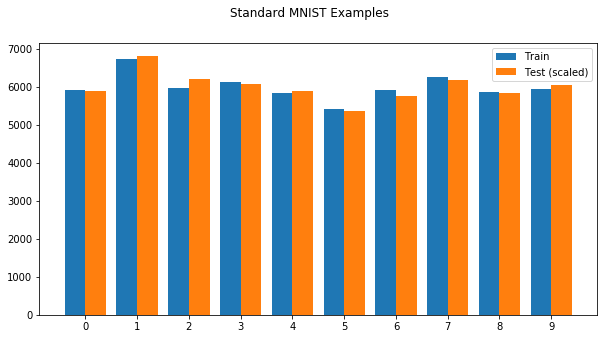

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Standard MNIST Examples')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.hist([train_dloader.dataset.targets.tolist(), test_dloader.dataset.targets.tolist()*6], 
        label=['Train', 'Test (scaled)'],
        bins=list(range(11)), 
        histtype='bar',
        align='left',
        rwidth=0.8,
       )
ax.legend();

NOTE: DO WE WANT TO JUST TRAIN THE BASELINE MODEL HERE BEFORE STACKING THE DECK?

AND THEN DO WE WANT TO SHOW A MODEL TRAINED ONLY ON ONE SKEWED DATASET?

### Stacking a Deck (Skewing the Data)

We know the baseline data is pretty even across numerals. Now we need a way to "stack the deck" of examples that each worker sees. This method creates a dataset that is randomly sampled from a given dataset with the random sampling biased according to a dictionary of weights for each label.

In [7]:
from torch.utils.data import WeightedRandomSampler

def stacked_dset(dset, label_weights, N):
    """
    dset: dataset
    label_weights = {dog: 0.5, cat: 0.3, ...}
    N: size of stacked dset
    return: stacked WeightedRandomSampler
    """
    weights = []
    for data, label in dset:
        weights.append(label_weights[label])

#     for label in test_dset.targets:
#         weights.append(label_weights[int(label)])
# TODO / MLW : how to speed this up - currently takes about a minute to train ten stacked training sets
    
    return WeightedRandomSampler(weights, N, replacement=False)

And this is where we get the dictionary of weights. For simplicity's sake, we just take a list of labels to be sampled "normally" and the rest are biased against. So, preserving 3s and skewing everything else by a factor of 0.9 shoud get a set of weights that results in a dataset that is slightly heavy on 3s compared to everything else. In an an extreme example, preserving only 3s, with a skew of 0, will produce weights that will yield a dataset of only 3s.

In [8]:
def skewed_weights(num_labels, labels_to_preserve, skew_bias):
    """
        num_labels: number of labels to return (use 10 for MNIST)
        labels_to_preserve: list of labels to preserve wih no skew 
        skew_bias: a float, 0 < bias < 1, to which non-selected labels will be biased down
        return: dictionary of each label and its bias
    """
    weights = {}
    for label in range(num_labels):
        if label in labels_to_preserve:
            weights[label] = 1
        else:
            weights[label] = skew_bias
    
    return weights

### 

Here we do the sampling to create our skewed datasets.

In [122]:
from tqdm import tqdm

# create stacked loaders for the workers

run_data['Skew Bias'] = skew_bias = 0.5
run_data['Examples Per Skewed Loader'] = loader_size = 512
run_data['Number of Workers'] = num_workers = 15

stacking_start_time = time.time()

stacked_data_loaders = []
for label in tqdm(range(num_workers)):
    stacked_sampler = stacked_dset(train_dset, skewed_weights(10, [label%10], skew_bias), loader_size)
    stacked_data_loaders.append(DataLoader(train_dset, batch_size=batch_size, shuffle=False, sampler=stacked_sampler))

run_data['Stacking Time'] = time.time() - stacking_start_time
run_data['Stacking Time per Loader'] = run_data['Stacking Time'] / run_data['Number of Workers']

print('Stacking Time: %.2f' % run_data['Stacking Time'])
print('Stacking Time per Loader: %.2f' % run_data['Stacking Time per Loader'])

100%|██████████| 15/15 [01:42<00:00,  6.67s/it]

Stacking Time: 102.90
Stacking Time per Loader: 6.86


We should see the effect of the skew in a count and histogram of a skewed dataset. Here, we arbitrarily picked the second dataloader.

In [123]:
_, ybatches = list(zip(*stacked_data_loaders[1]))
ys = torch.cat(ybatches)
ys = [int(y) for y in ys]
print (Counter(ys).most_common())

# counts = sorted(Counter(ys).most_common())
# print(counts)
# _, counts = zip(*counts)
# print(list(counts))


[(1, 104), (2, 64), (7, 50), (8, 46), (6, 45), (0, 44), (9, 42), (4, 41), (3, 39), (5, 37)]


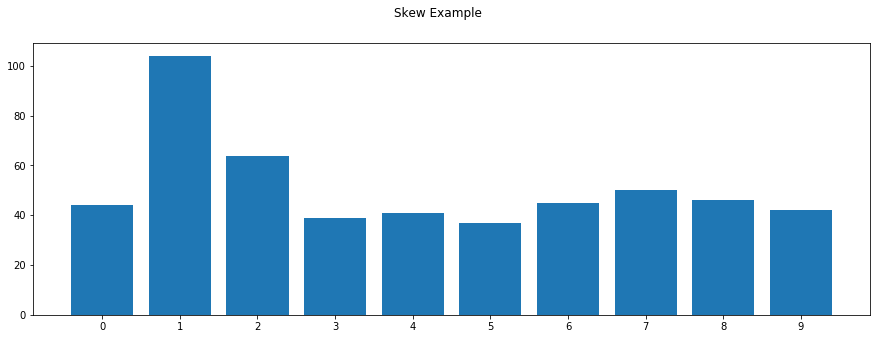

In [124]:
fig, ax = plt.subplots(figsize=(15, 5))
fig.suptitle('Skew Example')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
H = ax.hist(ys, bins=range(11), histtype='bar', align='left', rwidth=0.8)

In [125]:
hist_counts = []
digit_counts = []
for loader in tqdm(stacked_data_loaders):
    _, ybatches = list(zip(*loader))
    ys = torch.cat(ybatches)
    ys = [int(y) for y in ys]
    hist_counts.append(ys)
    
    digits = sorted(Counter(ys).most_common())
    _, digits = list(zip(*digits))
    digit_counts.append(list(digits))

digit_counts = [list(i) for i in zip(*digit_counts)]

100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


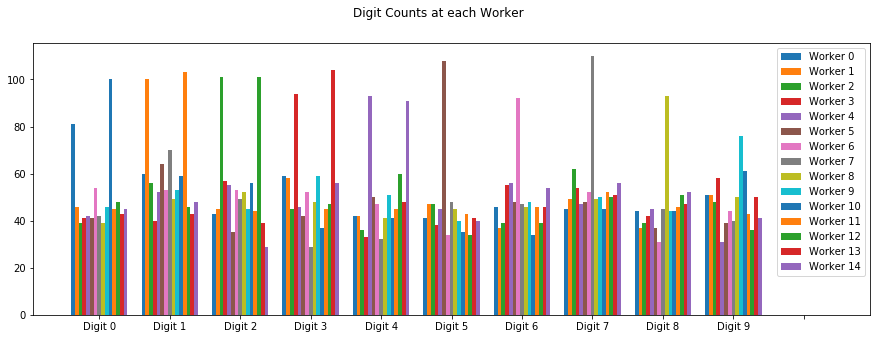

In [126]:
fig, ax = plt.subplots(figsize=(15, 5))
fig.suptitle('Digit Counts at each Worker')
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_xticklabels([('Digit ' + str(x-1)) for x in range(11)])
ax.hist(hist_counts, 
        label=[('Worker ' + str(x)) for x in range(num_workers)],
        bins=list(range(12)), 
        histtype='bar',
        align='left',
        rwidth=0.8,
       );
ax.legend();

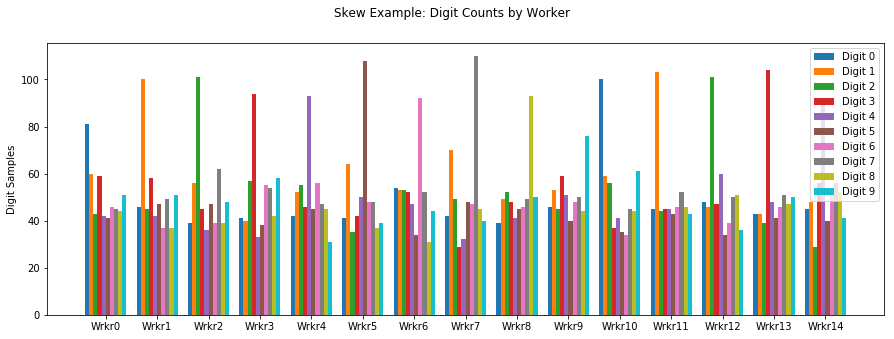

In [134]:
# fig, ax = plt.subplots(figsize=(15, 5))
# fig.suptitle('Skew Examples')
# ax.xaxis.set_major_locator(plt.MultipleLocator(10))
# ax.hist(digit_counts, 
#         label=[('Digit ' + str(x)) for x in range(11)],
#         bins=num_workers + 1, 
#         histtype='bar',
#         align='left',
#         rwidth=0.8,
#        );
# ax.legend();



fig, ax = plt.subplots(figsize=(15, 5))
fig.suptitle('Skew Example: Digit Counts by Worker')

pos = list(range(num_workers))
width = 0.08

for digit in range(10):
    ax.bar([p + (width * digit) for p in pos],
           digit_counts[digit],
           width = width,
           label = 'Digit ' + str(digit),
          )

ax.set_xticks([p + (4.5 * width) for p in pos])
ax.set_xticklabels([('Wrkr' + str(x)) for x in range(num_workers)])
ax.set_ylabel('Digit Samples')
ax.legend(loc = 'upper right');

In [ ]:
import federated

run_data['Learning Rate'] = learning_rate = 1e-2
run_data['Epochs per Round'] = num_epochs = 1
run_data['Federated Training Rounds'] = num_rounds = 50

skewed_train_dsets = stacked_data_loaders

manager = federated.FederatedManager(
    skewed_train_dsets,
    MLPNet,
    nn.CrossEntropyLoss(),
    learning_rate,
    test_dset,
    num_epochs
)

In [ ]:
print("Training", num_rounds, "round(s) with", manager.n_workers, "worker(s) doing", num_epochs, "epoch(s) per round.\n" )

training_start_time = time.time()

for i in tqdm(range(num_rounds)):
    print("Beginning round", i+1)
    manager.round()
    print("Finished round", i+1, "with global loss: %.5f" % manager.manager_loss_history[-1], "\n")

run_data['Federated Training Time'] = time.time() - training_start_time
run_data['Manager Loss History'] = manager.manager_loss_history
run_data['Worker Loss Histories'] = manager.worker_loss_histories


print('Federated Training Time: %.2f' % run_data['Federated Training Time'])

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 10))
# loss of global model on test set gets recorded twice per round
# [1::2] skips the record that takes place before that round's training has happened
ax.plot(manager.manager_loss_history[1::2], label="Global Loss", )
ax.set_xlabel("Round");
ax.legend();

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))

for i in range(len(manager.worker_loss_histories)):
    ax.plot(manager.worker_loss_histories[i], label=('Worker ' + str(i)))
    ax.legend();

TODO: Write a bit of code that records the hyperparameters and saves the graphs, times and losses in a bundle for each run. Something like:

```
2019-05-06 21:02:50

# standard dataloader parameter
batch_size = 128

# biasing parameters
skew_bias = 0.3
loader_size = 8192
num_workers = 10

Stacked set creation time: 00:01:08

# training parameters
learning_rate = 1e-2
num_epochs = 1
num_rounds = 20

Train time = 00:43:02

Final global loss: 0.48251
```

Well. I did this. And now the code is unreadable.

Outline:
- Set up a model and data
- train the model N epochs without federation note baseline performance (and size of the data that would have to have been transferedd?) 
    - is this model trained on the full dataset? Or do we sample randomly across it to have the same number of examples?
- Federate without skew or mild skew, compare performance with baseline (and size of model compared to data)
- Federate with only a few numbers skewed (like, lacking only 7s or something) 
- Federate with heavy skew
- Federate with complete skew

Ideas:
- plot performance on a given numeral for the main model next to that of a worker skewed against that numeral. Let both run without federation or run a few epochs before federation. Show this as a baseline
- histogram of numerals? More for curiosity, but shows spread of data that we might want to reflect in the baseline training.
- post 1: what's the accuracy loss for federation compared to baseline direct training?
- post 2: weird side stats
    - skew vs. accuracy
        - plot - x-axis = skew, y-axis = accuracy
    - run all to convergence, compare how long to reach comparable accuracy?
        - time or epochs necessary to reach comparable accuracy between federated and standard approach
        - time or epochs necessary to reach comparable accuracy by skew
    - 

Questions:
- Why does the time spent by a worker on any given epoch all happen _before_ the batches start rolling in? What's happening there? Am I just spinning my wheels on something?
    - TODO: try this from a regular python file. The notebook may be buffering up those print statements in the batches
- Why does random selection of the skewed datasets take so long? Is it because they're without replacement?
- Why do all the workers and epochs always happen in order? Wouldn't my laptop parallelize them across cores? Is that too much to ask from an interpreter? Is the interpreter smarter than I am and actually is parallelizing them and the smartest way in to do them in order?
- why use ten workers? Why not fewer?

In [ ]:
# a little performance info on the run
run_data['Global End Time'] = time.time()
run_data['Global Time'] = run_data['Global End Time'] - run_data['Global Start Time']
run_data

In [ ]:
# leave a record of the run
# but it isn't valid JSON
import json 
with open('run_data.json', 'a') as file:
    file.write(json.dumps(run_data))
    file.write('\n\n')